# Imports

In [37]:
import sys
sys.path.append("../Face_detection")
sys.path.append("../")

import glob
import zipfile
import os
import random
import cv2

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image
from sklearn.metrics import f1_score
from face_detection import predict_detected_faces
from data_augmenation_pipeline import DataAugmentationPipeline
from tensorflow.keras.applications import MobileNetV2, MobileNet, EfficientNetB0, ResNet50, InceptionV3, VGG16
from tensorflow.keras import regularizers, initializers, Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, SpatialDropout2D, GlobalMaxPooling2D, AveragePooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [38]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

tf.config.set_visible_devices(gpus[1], 'GPU')  # Select GPU:1

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Hyperparameter for the model

In [39]:
batch_size = 24
target_size = (224, 224)
learning_rate = 0.0001
kernel_s = (3, 3)
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)

# Data Augmentation

In [40]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.6195793051269638,
    shear_range=0.040957683397623304,
    zoom_range=0.01551975506551656,
    width_shift_range=0.04749344961536198,
    height_shift_range=0.09783741203747219,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

train_gen=train_datagen.flow_from_directory(
    'Train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_gen=valid_datagen.flow_from_directory(
    'Validate',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_gen=valid_datagen.flow_from_directory(
    'Test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 5569 images belonging to 5 classes.
Found 696 images belonging to 5 classes.
Found 697 images belonging to 5 classes.


# Plotting a batch of training data

Class labels: ['Asian', 'Black', 'Indian', 'Other', 'White']


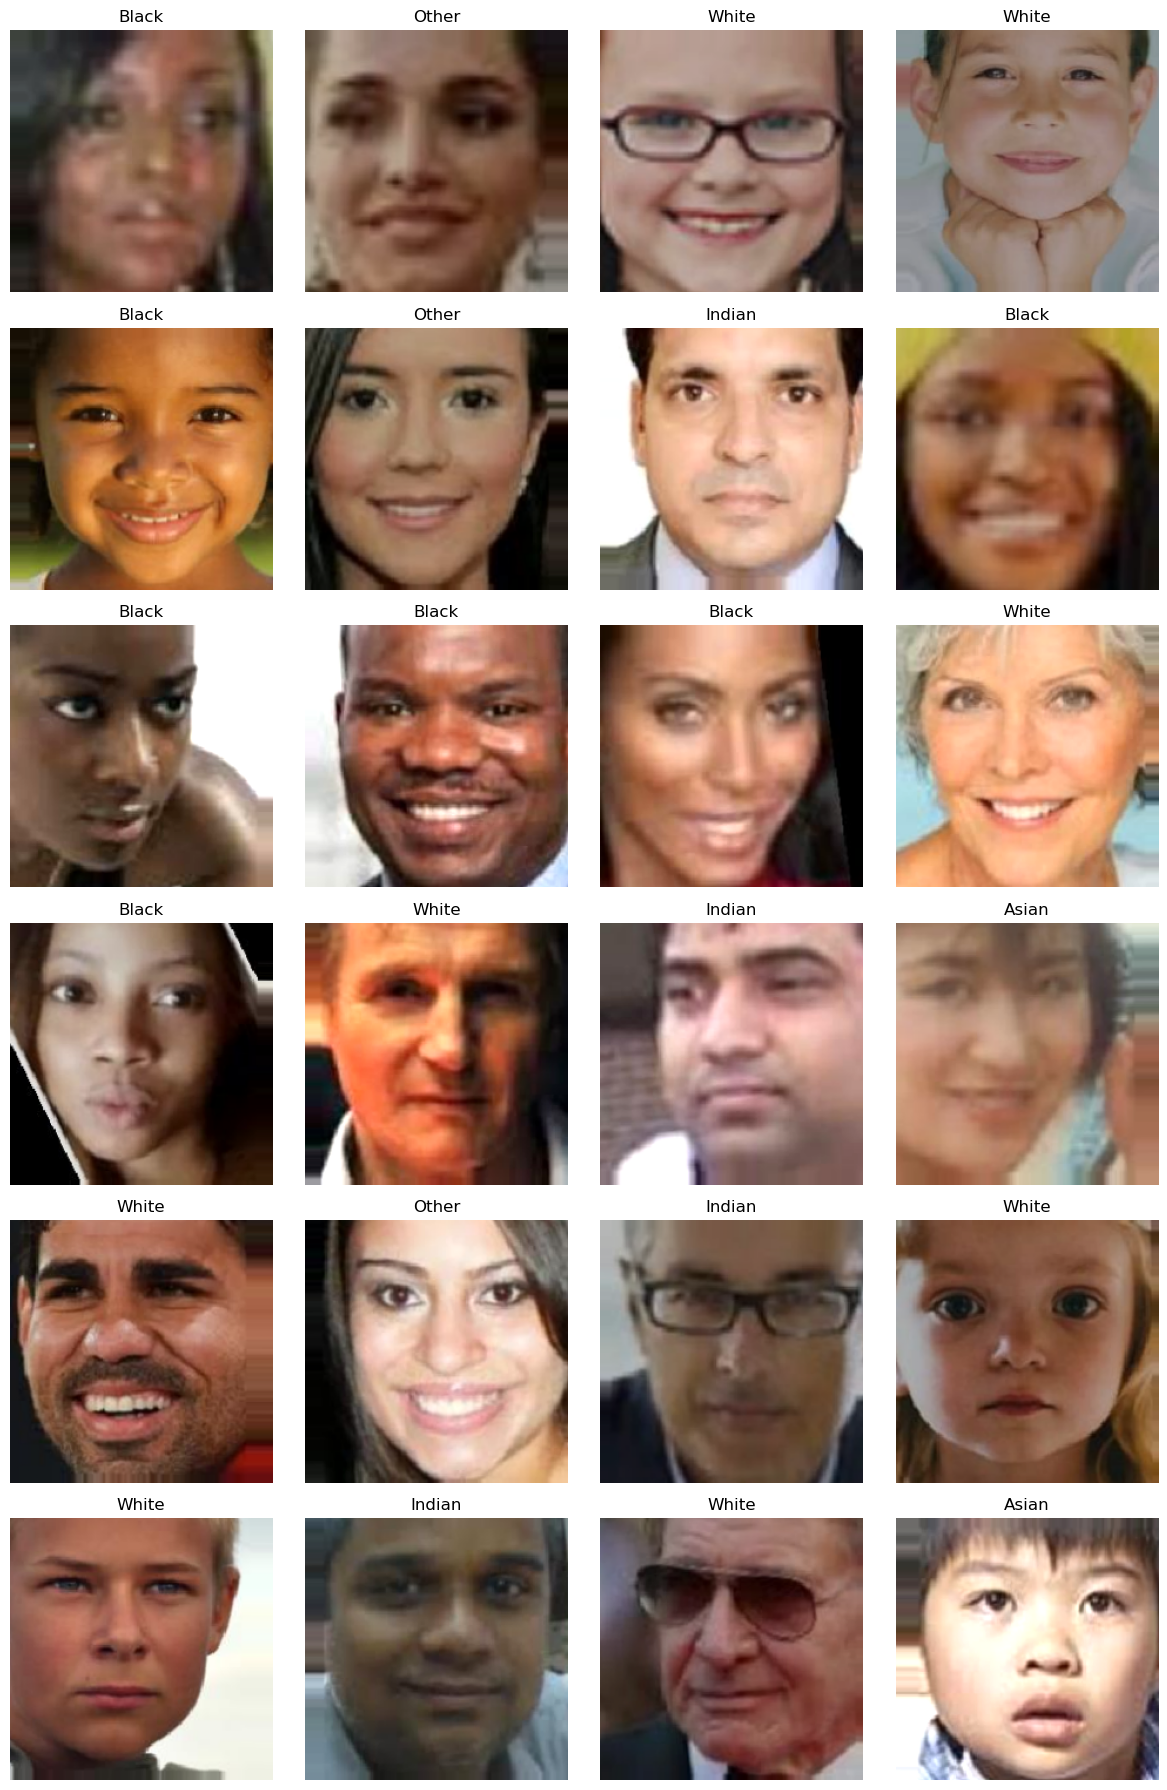

In [41]:
x_batch, y_batch = next(train_gen)
num_images = x_batch.shape[0]
cols = 4
rows = (num_images + cols - 1) // cols

class_labels = list(train_gen.class_indices.keys())
print(f"Class labels: {class_labels}")

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

for i in range(num_images):
    ax = axes[i]
    ax.imshow(x_batch[i])
    
    class_index = y_batch[i].argmax()
    label = class_labels[class_index]
    
    ax.set_title(label)
    ax.axis('off')

for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Set up and configure a model for training

In [42]:
# These two models are also not bad
# base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) # Is correct on the test data, but not on my own
# base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) # Works for my images, but isn't correct on the test data

# https://arxiv.org/abs/1409.4842 - Paper of the Inception architecture
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = False 

base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_23 (Flatten)        (None, 51200)             0         
                                                                 
 dense_46 (Dense)            (None, 1024)              52429824  
                                                                 
 dropout_23 (Dropout)        (None, 1024)              0         
                                                                 
 dense_47 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 74237733 (283.19 MB)
Trainable params: 59608261 (227.39 MB)
Non-trainable params: 14629472 (55.81 MB)
_________________________________________________________________


# Compile the model and start the training

In [43]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(
    train_gen,
    batch_size=batch_size,
    epochs=40,
    validation_data=valid_gen,
    steps_per_epoch=100,
    callbacks=[early_stopping]
)

Epoch 1/40
100/100 [==============================] - 32s 252ms/step - loss: 5.7283 - acc: 0.4266 - val_loss: 1.2549 - val_acc: 0.5718
Epoch 2/40
100/100 [==============================] - 25s 245ms/step - loss: 1.2448 - acc: 0.5499 - val_loss: 0.9815 - val_acc: 0.6207
Epoch 3/40
100/100 [==============================] - 24s 238ms/step - loss: 1.0560 - acc: 0.6323 - val_loss: 0.9831 - val_acc: 0.6494
Epoch 4/40
100/100 [==============================] - 25s 247ms/step - loss: 0.9914 - acc: 0.6471 - val_loss: 0.9378 - val_acc: 0.6782
Epoch 5/40
100/100 [==============================] - 24s 244ms/step - loss: 0.9354 - acc: 0.6779 - val_loss: 0.9569 - val_acc: 0.6695
Epoch 6/40
100/100 [==============================] - 24s 239ms/step - loss: 0.8629 - acc: 0.6996 - val_loss: 1.1585 - val_acc: 0.6566
Epoch 7/40
100/100 [==============================] - 25s 247ms/step - loss: 0.8853 - acc: 0.6967 - val_loss: 0.8312 - val_acc: 0.6882
Epoch 8/40
100/100 [==============================] - 2

# Data Augmenation Pipeline

In [35]:
def generate_random_config():
    return {
        'rotation': random.uniform(0, 10),             
        'zoom': random.uniform(0, 0.25),             
        'width_shift': random.uniform(0, 0.1),
        'height_shift': random.uniform(0, 0.1),
        'shear': random.uniform(0, 0.1),           
        'hflip': True,                                
        'brightness': random.choice([[0.7, 1.3], [0.8, 1.2], None]) 
}

results = []

for i in range(10):
    config = generate_random_config()
    print(f"\n[INFO] Running config {i+1}: {config}")
    pipeline = DataAugmentationPipeline(config=config, batch_size=batch_size, target_size=target_size, class_mode='categorical')
    
    train_gen = pipeline.get_train_generator()
    valid_gen = pipeline.get_valid_generator()
    test_gen = pipeline.get_test_generator()
    
    # Build the model for each iteration new
    base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    # base_model.trainable = False

    base_model.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['acc'])

    history = model.fit(
        train_gen,
        batch_size=batch_size,
        epochs=40,
        validation_data=valid_gen,
        steps_per_epoch=100,
        callbacks=[early_stopping]
    )
    
    # Evaluate on test dataset
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    
    results.append({
        'config': config,
        'val_acc': max(history.history['val_acc']),
        'test_acc': test_acc,
        'history': history.history
    })

# Sorted after best test accuracy
results = sorted(results, key=lambda x: x['test_acc'], reverse=True)

for r in results:
    print(f"\nConfig: {r['config']}\n-> Val Acc: {r['val_acc']:.4f} | Test Acc: {r['test_acc']:.4f}")


[INFO] Running config 1: {'rotation': 1.217339181891014, 'zoom': 0.17099303103209534, 'width_shift': 0.05598071631201319, 'height_shift': 0.040792720808534404, 'shear': 0.0961011572842596, 'hflip': True, 'brightness': None}
Found 5569 images belonging to 5 classes.
Found 696 images belonging to 5 classes.
Found 697 images belonging to 5 classes.
Epoch 1/40
100/100 [==============================] - 29s 223ms/step - loss: 7.2231 - acc: 0.4071 - val_loss: 1.1780 - val_acc: 0.5704
Epoch 2/40
100/100 [==============================] - 21s 208ms/step - loss: 1.1491 - acc: 0.5683 - val_loss: 1.0321 - val_acc: 0.6078
Epoch 3/40
100/100 [==============================] - 21s 209ms/step - loss: 1.0589 - acc: 0.6246 - val_loss: 1.1980 - val_acc: 0.5891
Epoch 4/40
100/100 [==============================] - 23s 232ms/step - loss: 1.0005 - acc: 0.6462 - val_loss: 1.0218 - val_acc: 0.6336
Epoch 5/40
100/100 [==============================] - 21s 208ms/step - loss: 1.0074 - acc: 0.6428 - val_loss: 1

# Plot the results of the training with a Data Augmentation Pipeline

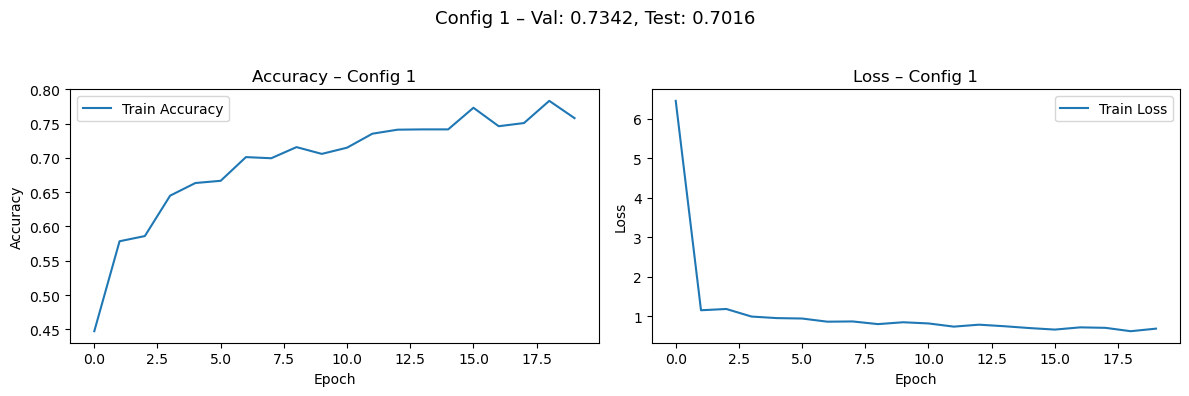

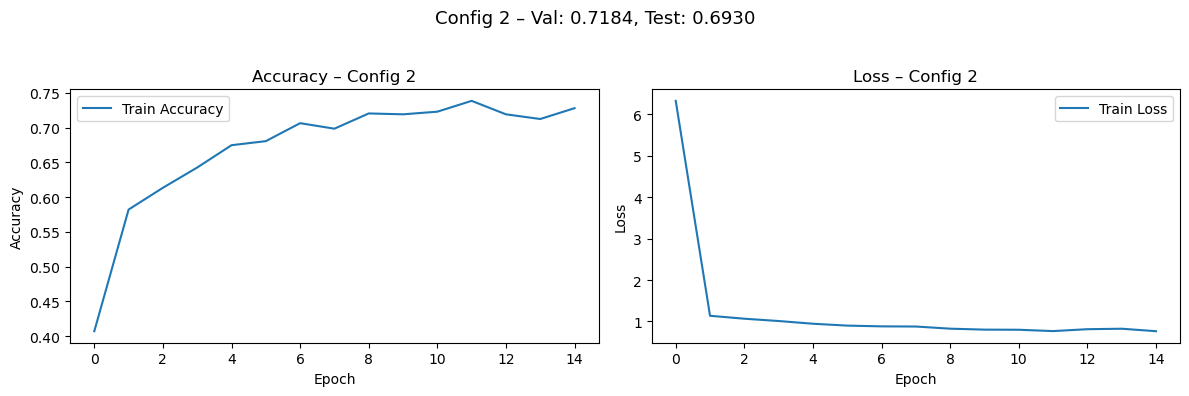

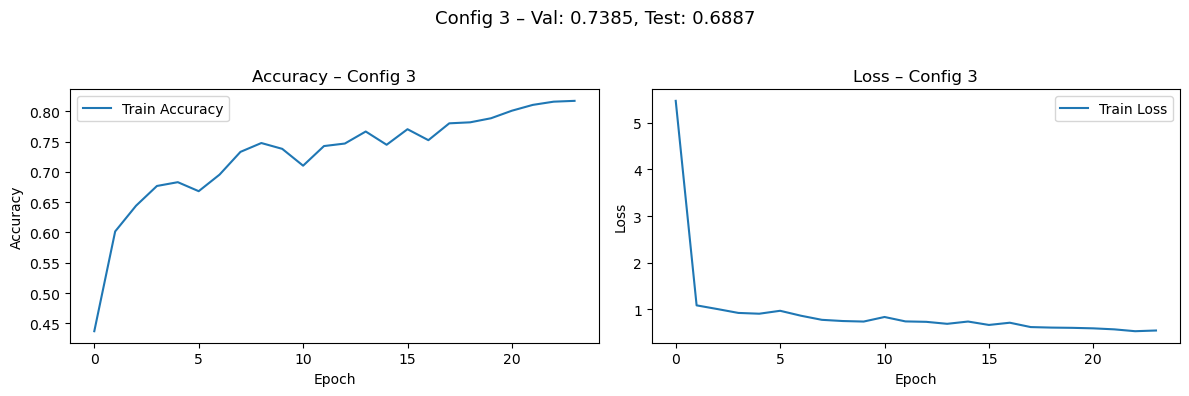

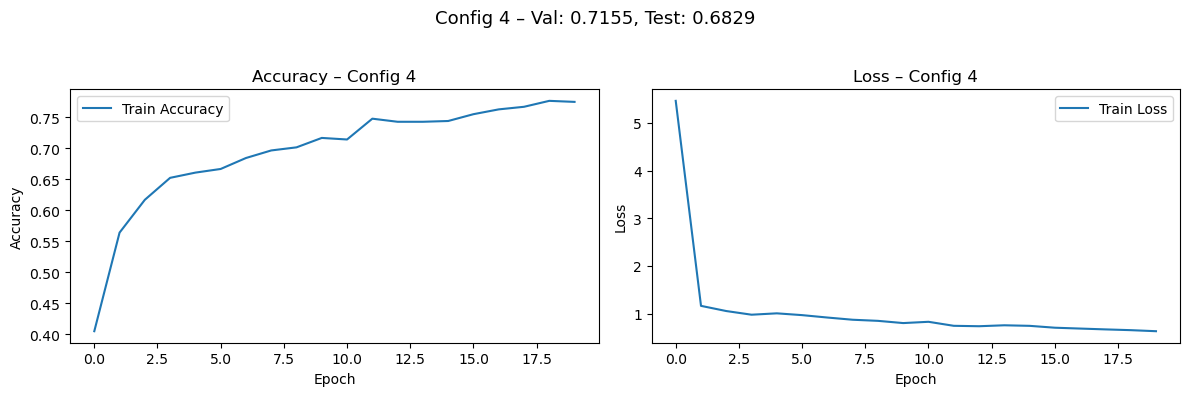

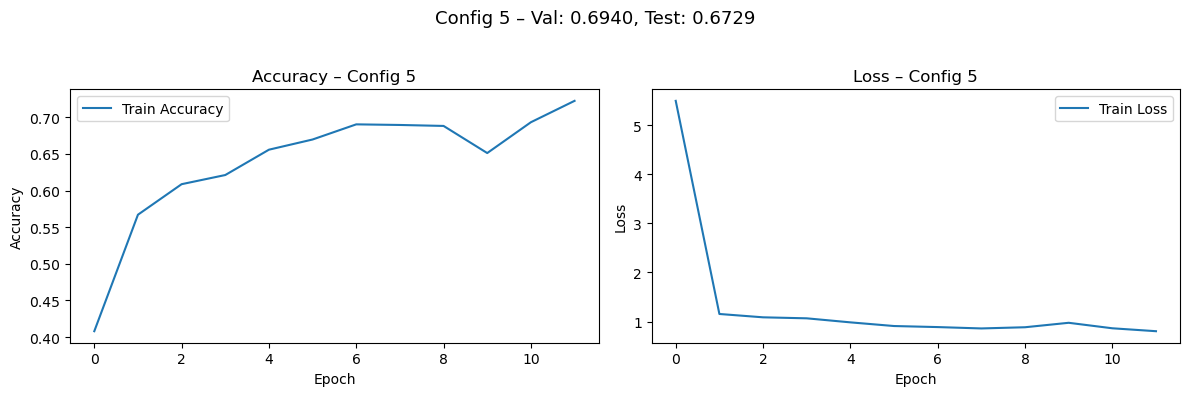

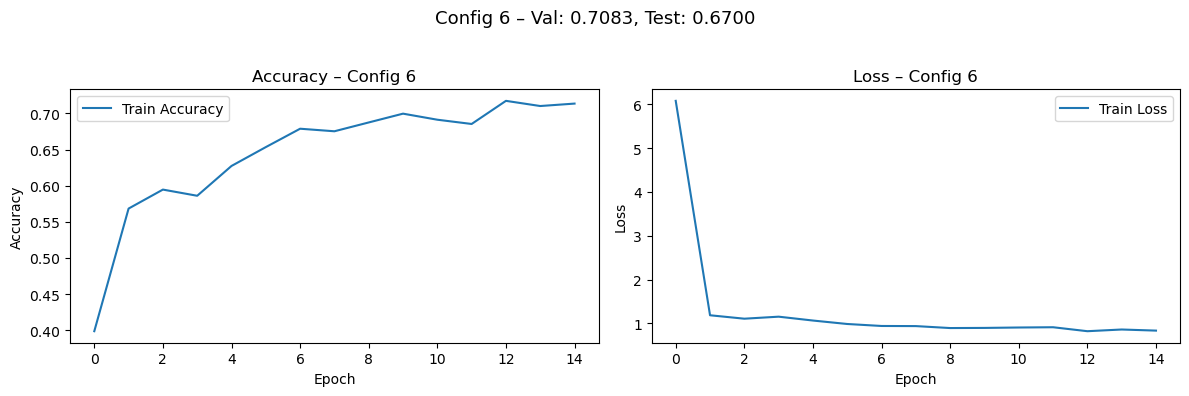

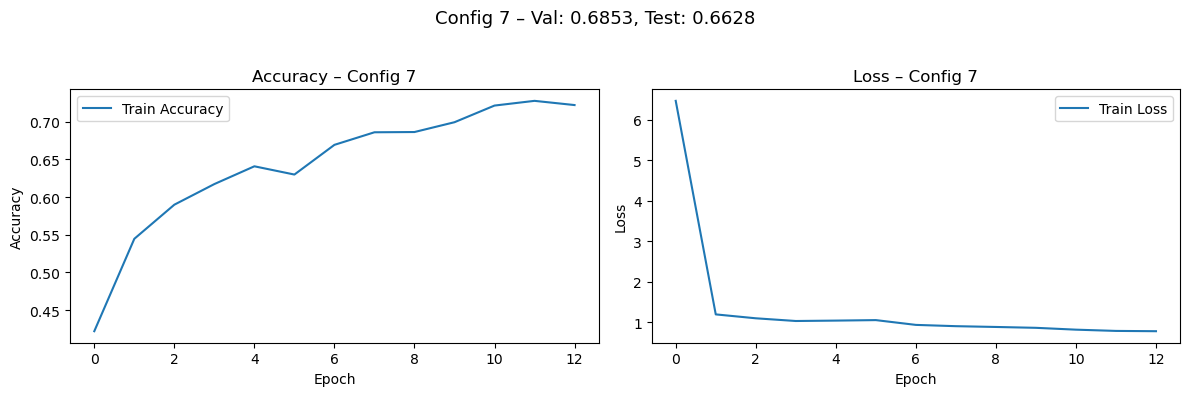

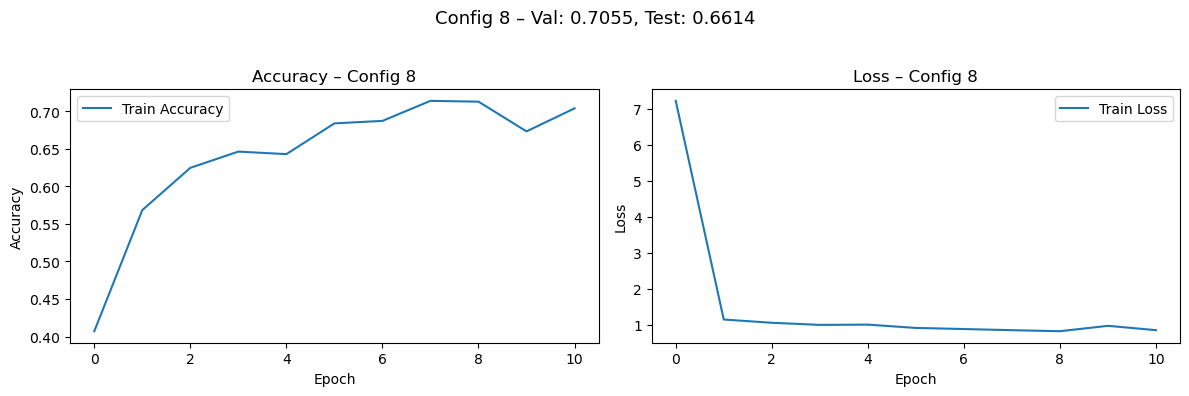

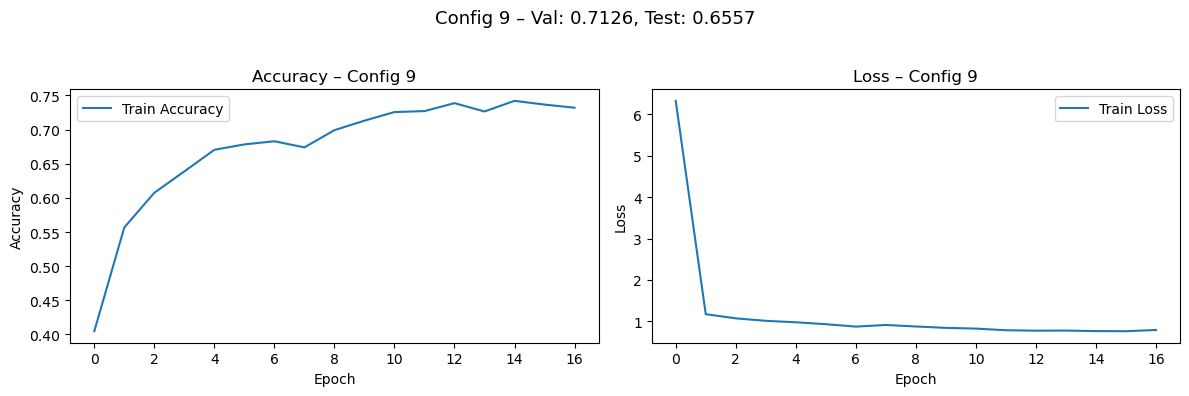

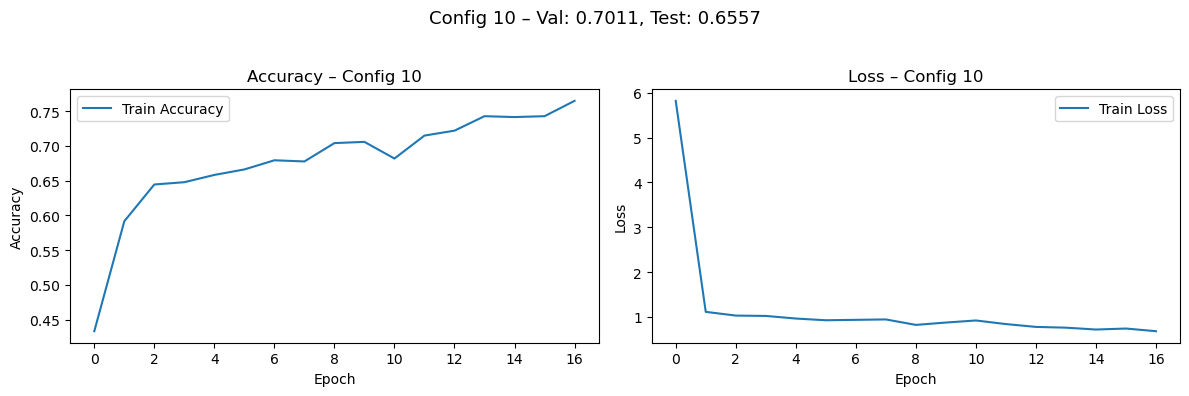

In [36]:
for i, r in enumerate(results):
    history = r.get('history', None)
    
    if history is None:
        print(f"[WARNING] No training history for config {i+1} available – please log the history.")
        continue

    config = r['config']
    val_acc = r['val_acc']
    test_acc = r['test_acc']

    acc_key = 'accuracy' if 'accuracy' in history else 'acc'
    val_acc_key = 'val_accuracy' if 'val_accuracy' in history else 'val_acc'

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history[acc_key], label='Train Accuracy')
    plt.title(f'Accuracy – Config {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.title(f'Loss – Config {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle(f'Config {i+1} – Val: {val_acc:.4f}, Test: {test_acc:.4f}', fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plot the results of the training

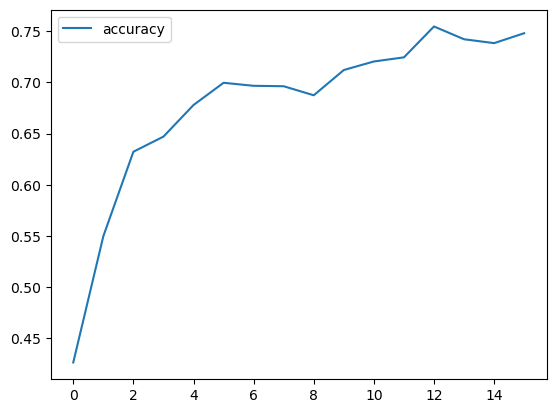

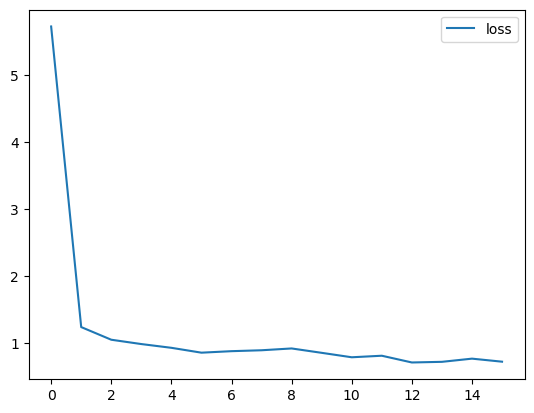

In [44]:
plt.plot(history.history['acc'], label='accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.legend()

# Test the model on the test data

1/1 [==============================] - 1s 1s/step


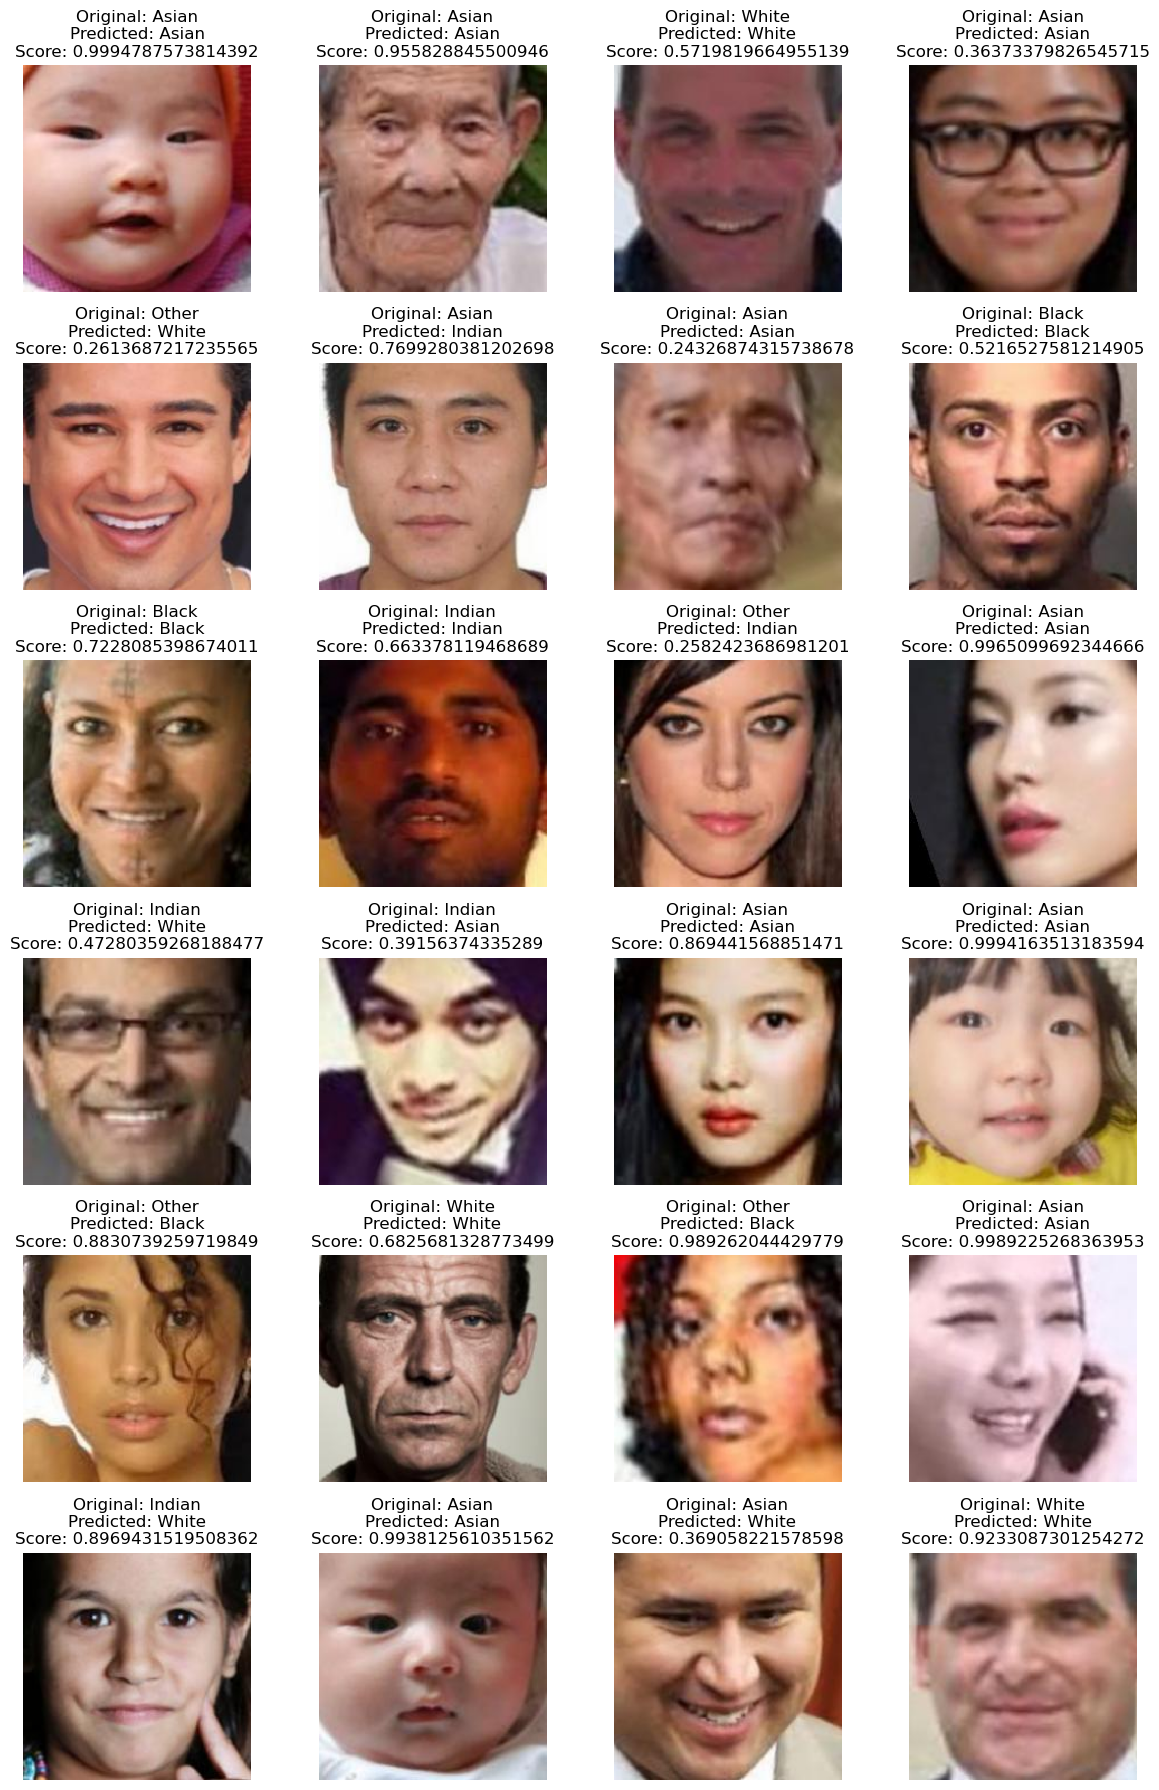

In [45]:
x_batch, y_batch = next(test_gen)
predictions = model.predict(x_batch)

predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_batch, axis=1)

num_images = x_batch.shape[0]
cols = 4
rows = (num_images + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

for i in range(num_images):
    ax = axes[i]
    ax.imshow(x_batch[i])

    true_label = class_labels[true_labels[i]]
    predicted_label = class_labels[predicted_labels[i]]
    prediction_score = predictions[i][predicted_labels[i]]

    ax.set_title(f"Original: {true_label}\nPredicted: {predicted_label}\nScore: {prediction_score}")
    ax.axis('off')

for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Test the model on my own data

1/1 [==============================] - 0s 36ms/step


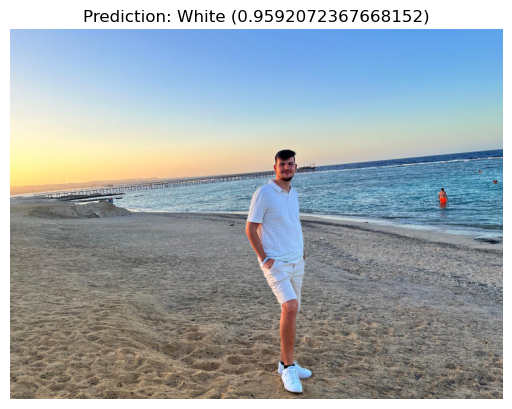

1/1 [==============================] - 0s 34ms/step


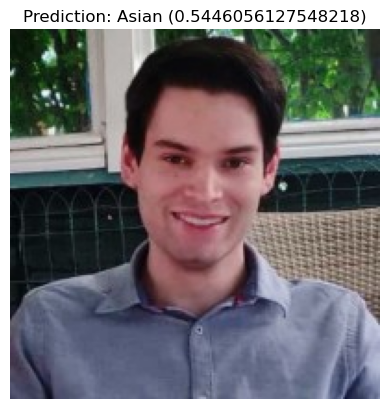

1/1 [==============================] - 0s 34ms/step


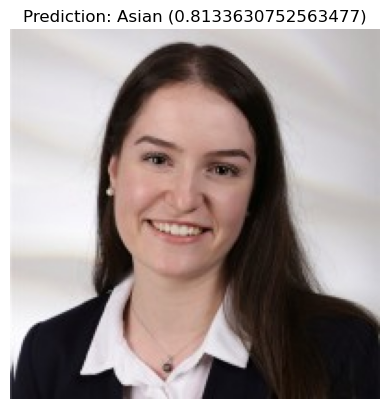

1/1 [==============================] - 0s 34ms/step


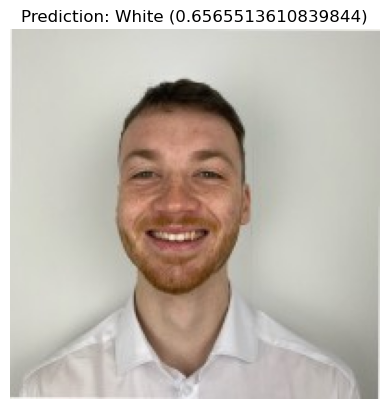

In [46]:
def edit_image(image_path: str) -> np.array: 
    img = load_img(image_path, target_size=target_size)

    img_array = img_to_array(img)
    img_array = img_array / 255.0 

    img_array = np.expand_dims(img_array, axis=0)

    return img_array

images = glob.glob('../Images/*.jpg')

for i, image in enumerate(images):
        img_array = edit_image(image)

        prediction = model.predict(img_array)

        predicted_label_index = np.argmax(prediction, axis=1)[0]
        predicted_label = class_labels[predicted_label_index]
        confidence = prediction[0][predicted_label_index]

        plt.imshow(load_img(image))
        plt.title(f"Prediction: {predicted_label} ({confidence:})")
        plt.axis("off")
        plt.show()

# Evaluate the model ans save it to a file

In [48]:
model.evaluate(test_gen)
model.save("../Models/With_DA_Pipeline/Nation_classification")

30/30 [==============================] - 1s 40ms/step - loss: 0.9933 - acc: 0.6930
INFO:tensorflow:Assets written to: ../Models/With_DA_Pipeline/Nation_classification/assets


INFO:tensorflow:Assets written to: ../Models/With_DA_Pipeline/Nation_classification/assets


# Test the model on detected and extracted faces

Loading the model: Nation_classification
Predicting with the model which was trained with the pipeline:
1/1 [==============================] - 1s 1s/step


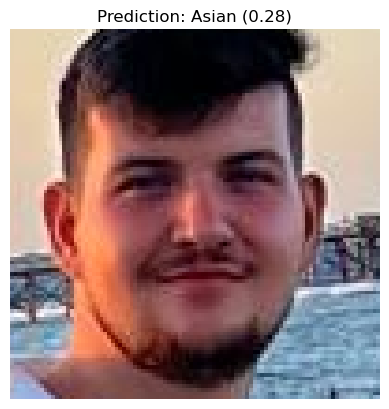

1/1 [==============================] - 0s 35ms/step


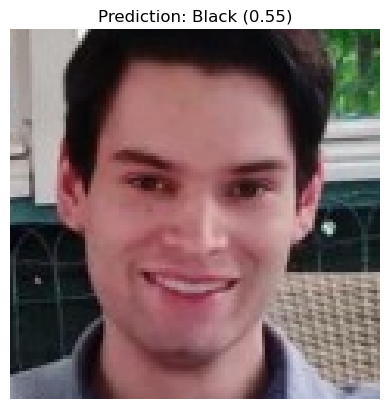

1/1 [==============================] - 0s 34ms/step


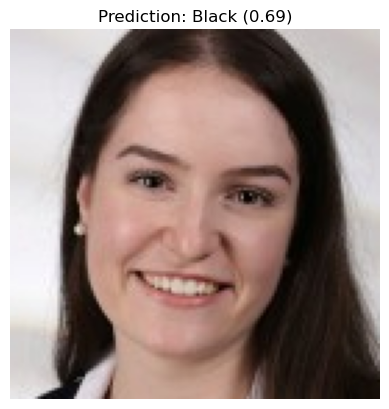

1/1 [==============================] - 0s 35ms/step


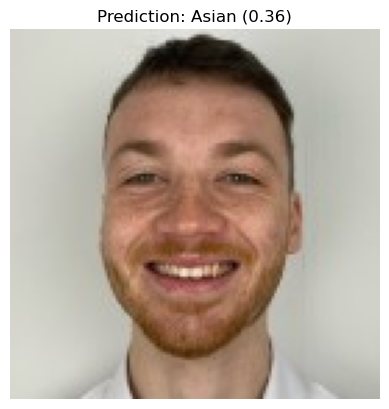

Predicting with the model which was trained without the pipeline:
1/1 [==============================] - 1s 1s/step


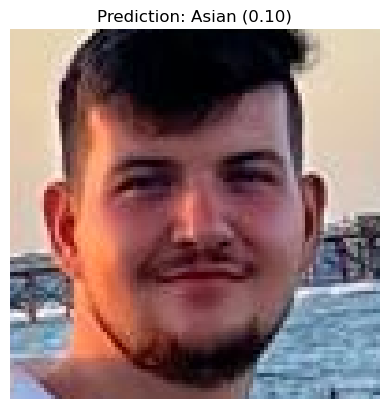

1/1 [==============================] - 0s 37ms/step


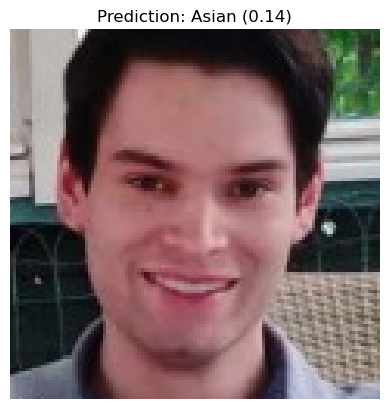

1/1 [==============================] - 0s 34ms/step


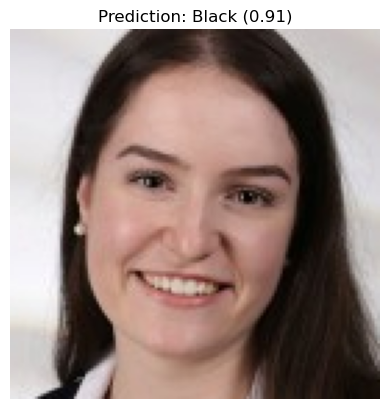

1/1 [==============================] - 0s 34ms/step


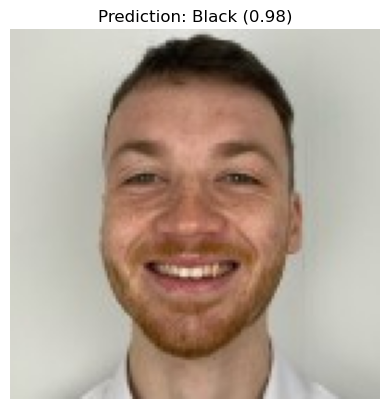

In [50]:
print(f"Loading the model: Nation_classification")
model_with_pipeline = load_model("../Models/With_DA_Pipeline/Nation_classification")
model_without_pipeline = load_model("../Models/Without_DA_Pipeline/Nation_classification")

print("Predicting with the model which was trained with the pipeline:")
predict_detected_faces(model=model_with_pipeline, class_names=class_labels, padding=0.2, image_directory="../Images/*.jpg")

print("Predicting with the model which was trained without the pipeline:")
predict_detected_faces(model=model_without_pipeline, class_names=class_labels, padding=0.2, image_directory="../Images/*.jpg")